In [40]:
from numpy import load
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

data = load('/content/drive/MyDrive/PathMNIST/pathmnist.npz')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
lst = data.files
print(len(lst))
print("Adatok:")
for i in range(6):
    print(lst[i],':',len(data[lst[i]]), "db")

6
Adatok:
train_images : 89996 db
val_images : 10004 db
test_images : 7180 db
train_labels : 89996 db
val_labels : 10004 db
test_labels : 7180 db


In [53]:
target = [] #---> 0,1,2,3
image_data = [] #---->array

target = np.concatenate((data[lst[3]].flatten(), data[lst[4]].flatten(),data[lst[5]].flatten()))
image_data = np.concatenate((data[lst[0]], data[lst[1]],data[lst[2]]))

print(len(target))
print(len(image_data))

data_size = len(target)


107180
107180


In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_data,target, test_size=0.2)

In [55]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
import warnings
warnings.filterwarnings('ignore')

In [56]:
class ArrayDataset(Dataset):
    "Sample numpy array dataset"
    def __init__(self, x, y):
        self.x, self.y = x, y
        self.c = len(np.unique(y))
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [57]:
print(len(X_train))
print(len(X_test))

train_s = len(X_train)
test_s = len(X_test)

85744
21436


In [58]:


X_train = X_train.reshape(train_s,3,28,28)
X_test = X_test.reshape(test_s,3,28,28)

X_test = X_test/255.0
X_train = X_train/255.0

#X_test = X_test.float()
#X_train = float(X_train)

X_train_t = tensor(X_train)
X_test_t = tensor(X_test)

y_train_t = tensor(y_train)
y_test_t = tensor(y_test)

In [59]:
#X_train = torch.Tensor(X_train).reshape(-1,3,28,28)
#X_test = torch.Tensor(X_test).reshape(-1,3,28,28)



#X_test = X_test.float()
#X_train = X_train.float()

#y_train = torch.Tensor(y_train)
#y_test = torch.Tensor(y_test)

#y_test = y_test.float()
#y_train = y_train.float()

In [60]:
train_d = ArrayDataset(X_train_t.float(),y_train_t.long())
valid_d = ArrayDataset(X_test_t.float(), y_test_t.long())

In [61]:
bs = 128
databunch = DataBunch.create(train_d, valid_d, bs=bs)

In [62]:
learn = cnn_learner(databunch, models.resnet34, metrics = [accuracy])

In [64]:
learn.loss_func

<function torch.nn.functional.nll_loss>

In [65]:
learn.loss_func = F.cross_entropy

In [66]:
learn.loss_func


<function torch.nn.functional.cross_entropy>

In [73]:
learn.fit_one_cycle(30)

epoch,train_loss,valid_loss,accuracy,time
0,1.784218,1.521499,0.637852,00:34
1,1.675934,1.276534,0.658332,00:34
2,1.511218,1.373986,0.675592,00:34
3,1.312876,1.311029,0.643637,00:34
4,1.322531,1.197363,0.723829,00:34
5,0.943858,37.773949,0.751679,00:34
6,0.861422,0.813576,0.743982,00:34
7,0.719793,0.981335,0.691873,00:34
8,0.621804,2.151206,0.648908,00:34
9,0.505124,1.205889,0.643917,00:34


In [74]:
# Save the model
learn.save('stage-1')
# Load the Model
learn.load('stage-1')

Learner(data=DataBunch;

Train: <__main__.ArrayDataset object at 0x7ff992b86a90>;

Valid: <__main__.ArrayDataset object at 0x7ff990daf780>;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, k

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Failed to compute the gradients, there might not be enough points.


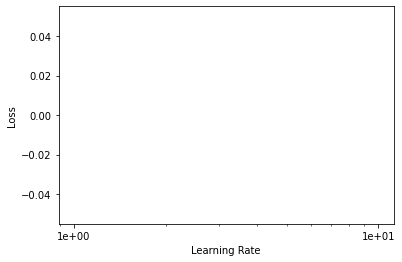

In [77]:
# Unfreeze all layers of the CNN
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [78]:
# Fit the model over 2 epochs
learn.fit_one_cycle(2, max_lr=slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.001533,1.273754,0.843394,00:34
1,0.002369,1.265843,0.843348,00:34
